In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Generating the data
N = 100
L = 1000
T = 20
x = np.empty((N,L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1/T).astype(np.float32)

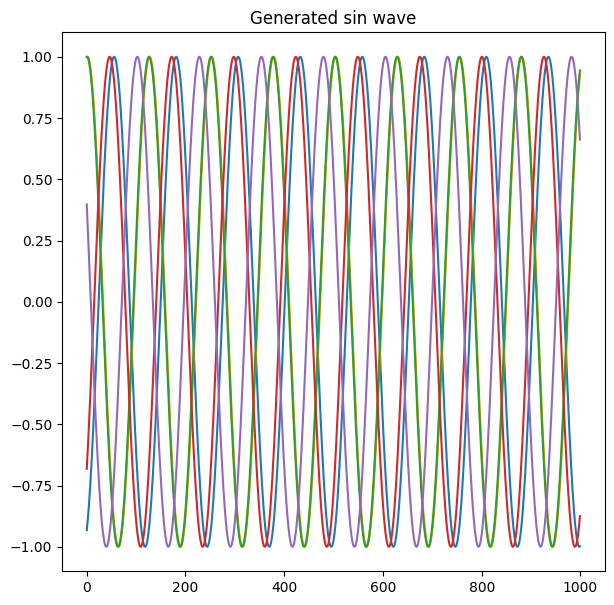

In [5]:
plt.figure(figsize=(7,7))
plt.title("Generated sin wave")
for i in range(5):
    plt.plot(np.arange(x.shape[1]), y[i,:])
plt.show()

In [6]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor,self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
        
    def forward(self, x, future=0): # future vaule is the number of further prediction
        outputs = []
        n_sample = x.size(0)
        h_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        return outputs
    
class LSTMPredictor2(nn.Module): # this scrip used to train the model with GPU
    def __init__(self, n_hidden=51):
        super(LSTMPredictor2,self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
        
    def forward(self, x, future=0): # future vaule is the number of further prediction
        outputs = []
        n_sample = x.size(0)
        h_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        c_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        return outputs
        

In [7]:
def draw(y_i,color):
    plt.plot(np.arange(n), y_i[:n],color,linewidth=2.0)
    plt.plot(np.arange(n,n+future), y_i[n:], color+":", linewidth=2.0)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99


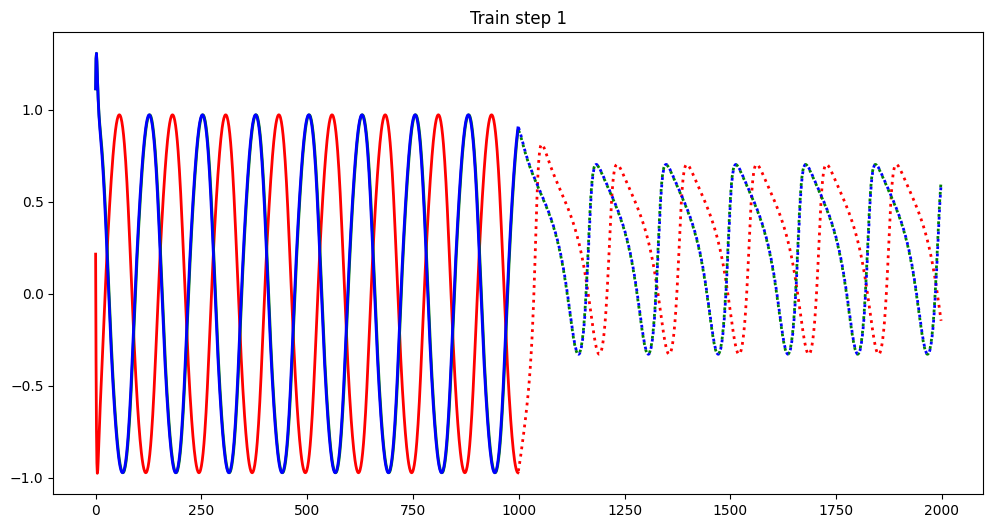

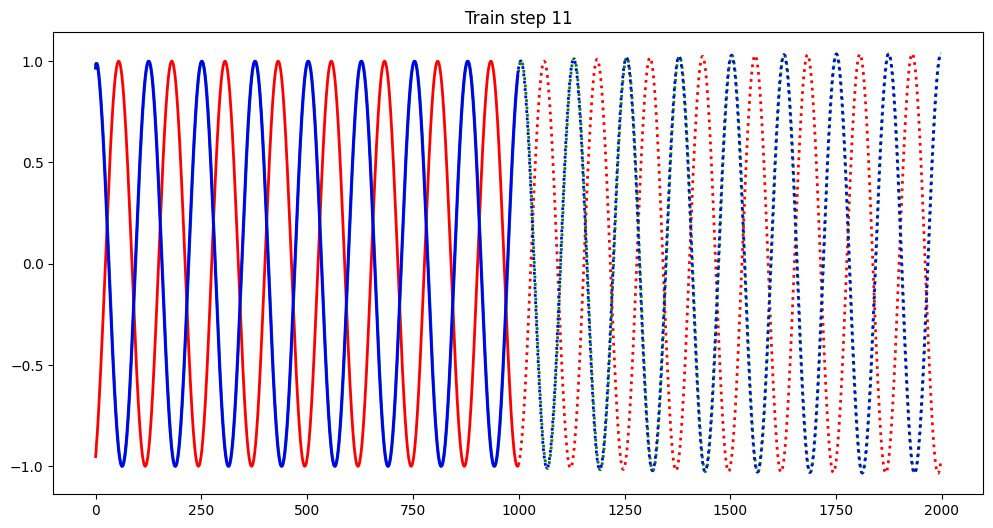

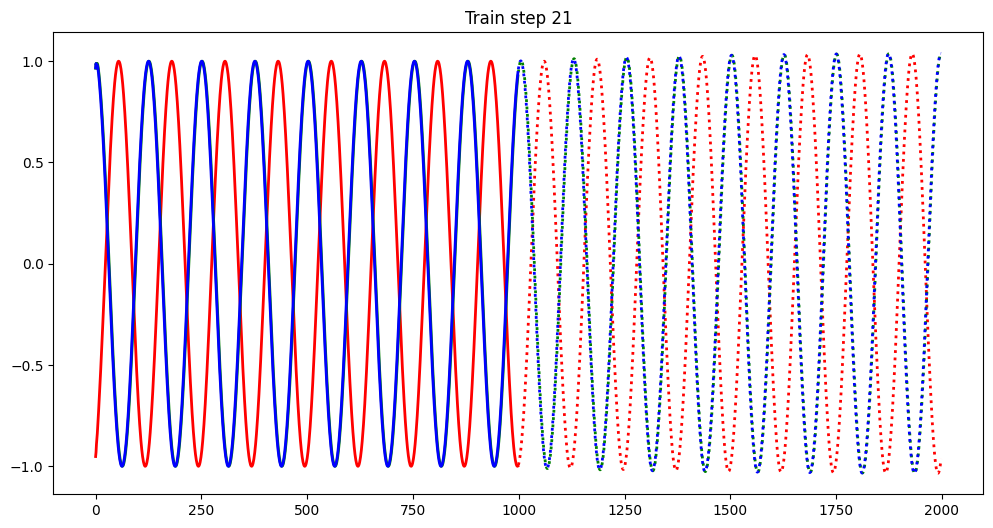

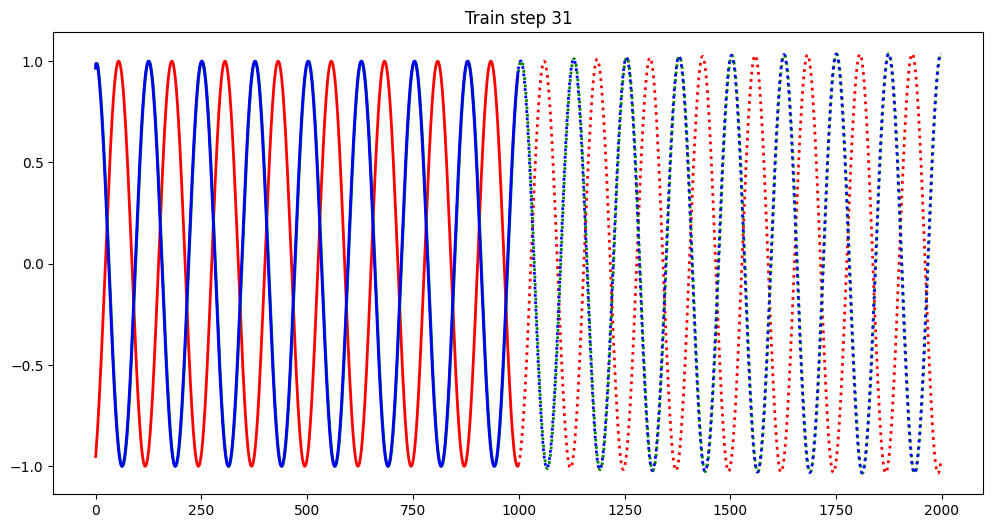

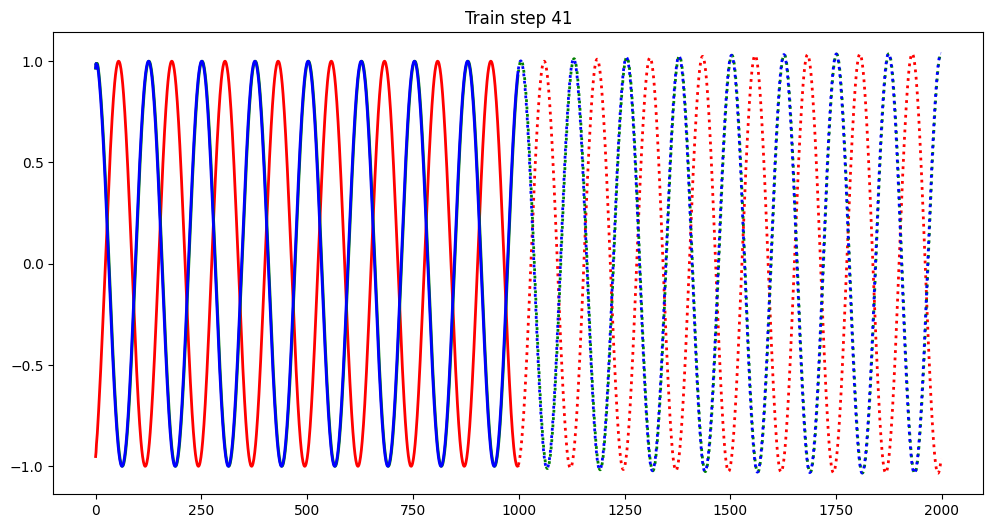

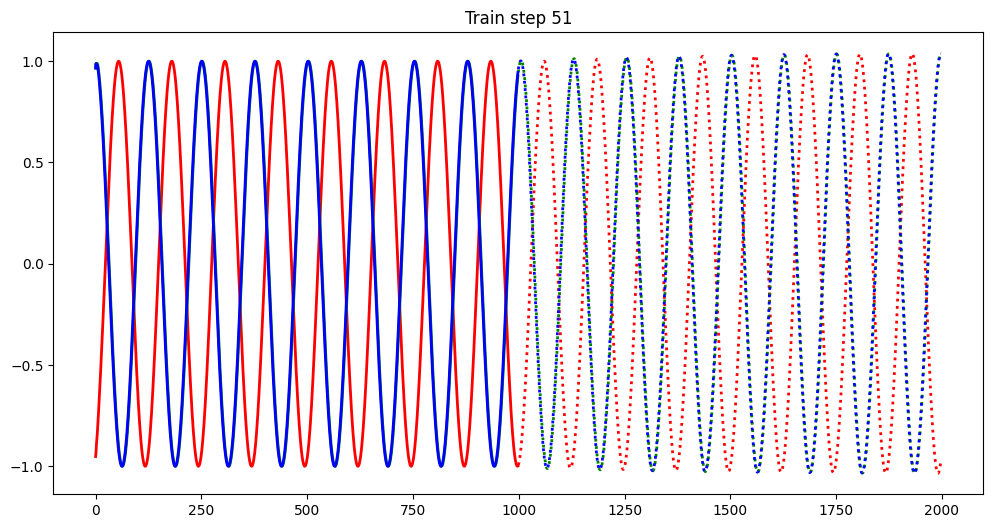

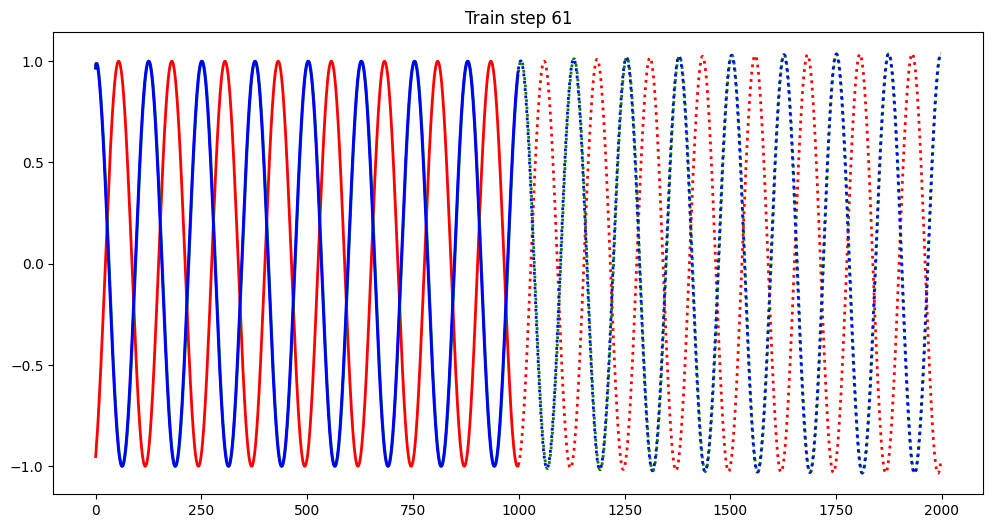

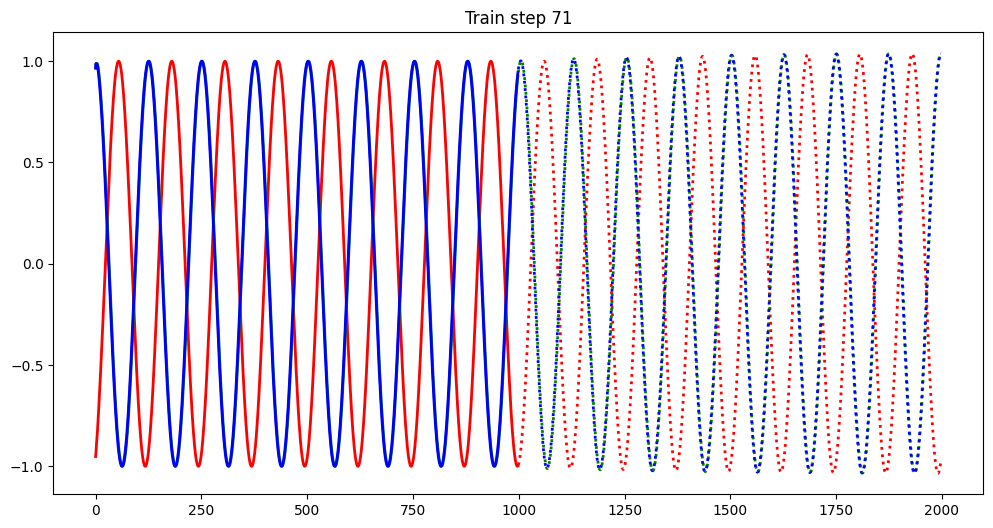

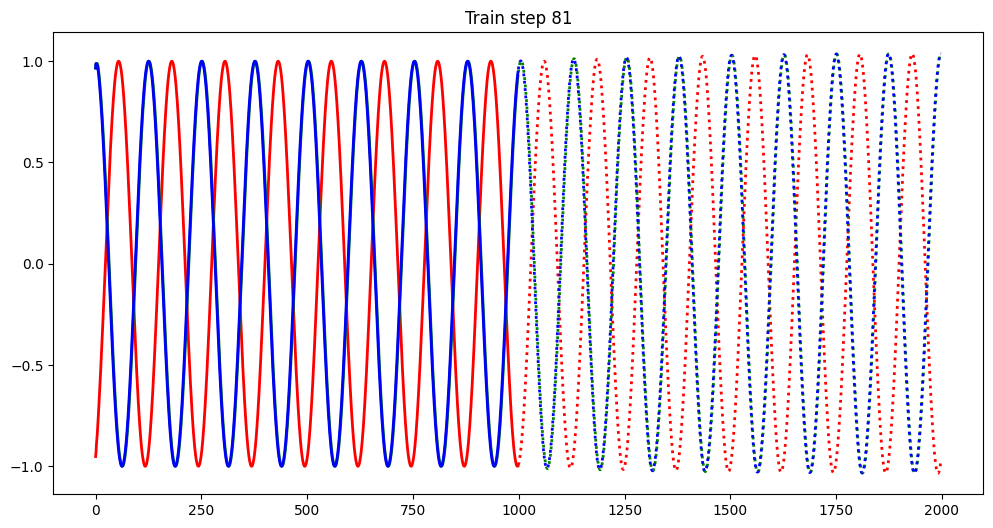

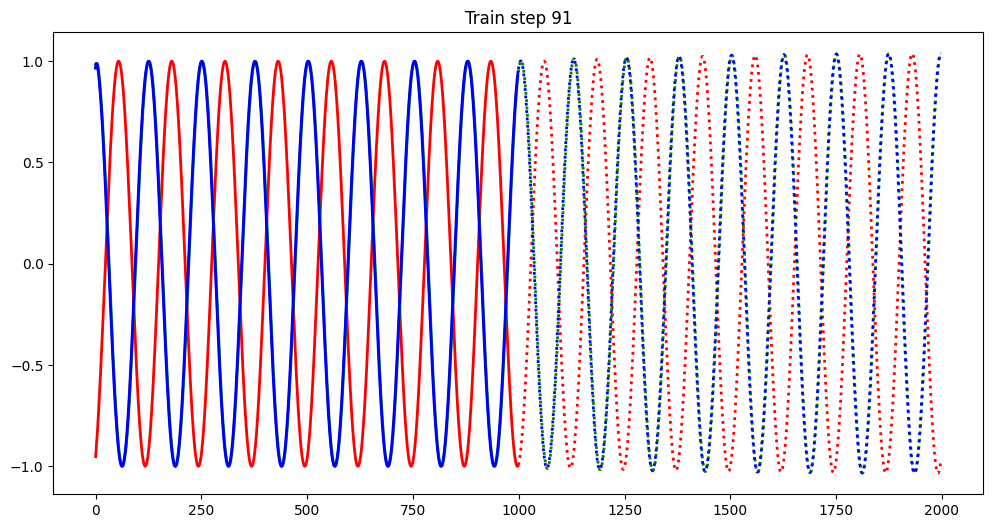

In [8]:
# y=100 , 1000
train_input = torch.from_numpy(y[3:,:-1]).to(device) #91, 999
train_target = torch.from_numpy(y[3:,1:]).to(device) #97, 999
test_input = torch.from_numpy(y[:3,:-1]).to(device) #3, 999
test_target = torch.from_numpy(y[:3,1:]).to(device) #3, 999

model = LSTMPredictor2()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr= 0.8)


n_iters = 100

for i in range(n_iters):
    print("Step",i)
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    
    if i % 10 == 0:
        with torch.no_grad():
            future = 1000
            pred = model(test_input,future=1000)
            loss = criterion(pred[:,:-future], test_target)
            pred = pred.to("cpu") # move data from GPU to cpu
            y = pred.detach().numpy()
        plt.figure(figsize=(12,6))
        plt.title(f"Train step {i+1}")
        n = train_input.shape[1]
        draw(y[0],'r')
        draw(y[1],'g')
        draw(y[2],'b')
    
    


In [11]:
train_input.shape

torch.Size([97, 999])

In [17]:
a = train_input.split(1,dim=1)

In [19]:
a[0].shape

torch.Size([97, 1])

In [87]:
test = model(torch.tensor([[1]],dtype=torch.float32).to(device),future=100)

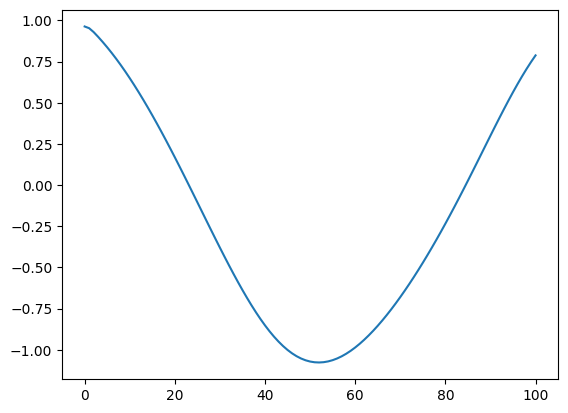

In [88]:
test = test.to("cpu").detach().numpy()
plt.plot(np.arange(len(test[0])),test[0])
plt.show()